# CHRONOS EXECUTION EXAMPLE
This notebook follows the minimal execution example from [chronos](https://github.com/amazon-science/chronos-forecasting/tree/main).



installation (move to docker)

In [1]:
#! pip install git+https://github.com/amazon-science/chronos-forecasting.git

In [2]:
import pandas as pd  # requires: pip install pandas
import torch
from chronos import ChronosPipeline
from dvats.all import *

/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(



Octave is ready <oct2py.core.Oct2Py object at 0x7f390b7ecd00>

















## Load Model

In [3]:
timer = dvats.utils.Time()

In [4]:
timer.start()
pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-small",
    device_map="cuda",  # use "cpu" for CPU inference and "mps" for Apple Silicon
    torch_dtype=torch.bfloat16,
)
timer.end()

config.json:   0%|          | 0.00/1.11k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/185M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/142 [00:00<?, ?B/s]

1726668165.3835816

In [5]:
timer.show()

[] Start: 1726668127.5533586 | End: 1726668165.3835816 | Duration: 37.830223083496094 seconds


37.830223083496094

## Load Dataset

In [6]:
df = pd.read_csv("https://raw.githubusercontent.com/AileenNielsen/TimeSeriesAnalysisWithPython/master/data/AirPassengers.csv")

In [7]:
df.shape

(144, 2)

## Get prediction

In [8]:
# context must be either a 1D tensor, a list of 1D tensors,
# or a left-padded 2D tensor with batch as the first dimension
# forecast shape: [num_series, num_samples, prediction_length]
forecast = pipeline.predict(
    context=torch.tensor(df["#Passengers"]),
    prediction_length=12,
    num_samples=20,
)

## Show prediction

In [9]:
import matplotlib.pyplot as plt  # requires: pip install matplotlib
import numpy as np

In [10]:
forecast_index = range(len(df), len(df) + 12)
low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)

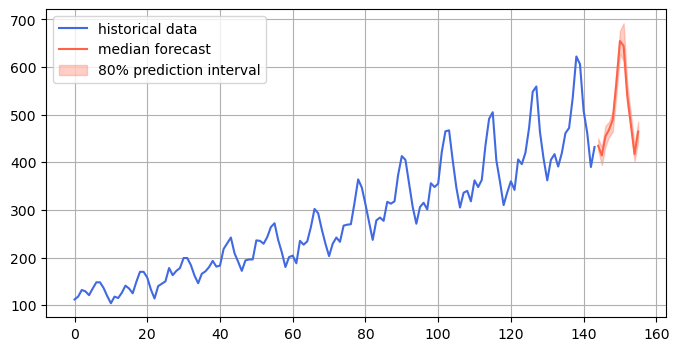

In [11]:
plt.figure(figsize=(8, 4))
plt.plot(df["#Passengers"], color="royalblue", label="historical data")
plt.plot(forecast_index, median, color="tomato", label="median forecast")
plt.fill_between(forecast_index, low, high, color="tomato", alpha=0.3, label="80% prediction interval")
plt.legend()
plt.grid()
plt.show()

## Extract encoder embeddings

In [12]:
# context must be either a 1D tensor, a list of 1D tensors,
# or a left-padded 2D tensor with batch as the first dimension
context = torch.tensor(df["#Passengers"])
embeddings, tokenizer_state = pipeline.embed(context)

In [13]:
embeddings.shape

torch.Size([1, 145, 512])

# Dimensionality reduction
In this part we add our dimensionality reduction to check the 2D vision of the embeddings shape

In [14]:
import numpy as np
import hdbscan

In [15]:
umap_params = {
    'n_neighbors' : 10,
    'min_dist' : 0.01,
    'random_state': 1234
}

In [16]:
embs = embeddings[0].to(torch.float32).numpy()

In [17]:
embs.shape

(145, 512)

In [18]:
prjs = get_UMAP_prjs(embs, cpu=False, **umap_params)

GPU | Used mem: 2
GPU | Used mem: 24
GPU | Memory Usage: [█-------------------] 8%
-- cuml.UMAP -- False
GPU | Used mem: 3
GPU | Used mem: 24
GPU | Memory Usage: [██------------------] 12%


In [19]:
prjs.shape

(145, 2)

In [20]:
# Define HDBSCAN parameters
hdbscan_kwargs = {
    'min_cluster_size' : 5,
    'min_samples' : 7,
    'cluster_selection_epsilon' : 0.0001,
}
metric_kwargs = {
    'metric' : 'euclidean' #'jaccard' 
}

In [21]:
# Create clusters using HDBSCAN
clusters = hdbscan.HDBSCAN(**hdbscan_kwargs, **metric_kwargs).fit(prjs)
clusters_labels = clusters.labels_

In [22]:
#| export
def plot_projections(prjs, umap_params, fig_size = (25,25)):
    "Plot 2D projections thorugh a connected scatter plot"
    df_prjs = pd.DataFrame(prjs, columns = ['x1', 'x2'])
    fig = plt.figure(figsize=(fig_size[0],fig_size[1]))
    ax = fig.add_subplot(111)
    ax.scatter(df_prjs['x1'], df_prjs['x2'], marker='o', facecolors='none', edgecolors='b', alpha=0.1)
    ax.plot(df_prjs['x1'], df_prjs['x2'], alpha=0.5, picker=1)
    plt.title('DR params -  n_neighbors:{:d} min_dist:{:f}'.format(
        umap_params['n_neighbors'],umap_params['min_dist']))
    return ax

In [23]:
#| export
# Color cluster & lines out
def plot_projections_clusters(prjs, clusters_labels, umap_params, fig_size = (25,25)):
    "Plot 2D projections thorugh a connected scatter plot"
    df_prjs = pd.DataFrame(prjs, columns = ['x1', 'x2'])
    df_prjs['cluster'] = clusters_labels
    
    fig = plt.figure(figsize=(fig_size[0],fig_size[1]))
    ax = fig.add_subplot(111)
    
    # Create a scatter plot for each cluster with different colors
    unique_labels = df_prjs['cluster'].unique()
    print(unique_labels)
    for label in unique_labels:
        cluster_data = df_prjs[df_prjs['cluster'] == label]
        ax.scatter(cluster_data['x1'], cluster_data['x2'], label=f'Cluster {label}')
        #ax.scatter(df_prjs['x1'], df_prjs['x2'], marker='o', facecolors='none', edgecolors='b', alpha=0.1)
    
    #ax.plot(df_prjs['x1'], df_prjs['x2'], alpha=0.5, picker=1)
    plt.title('DR params -  n_neighbors:{:d} min_dist:{:f}'.format(
        umap_params['n_neighbors'],umap_params['min_dist']))
    return ax

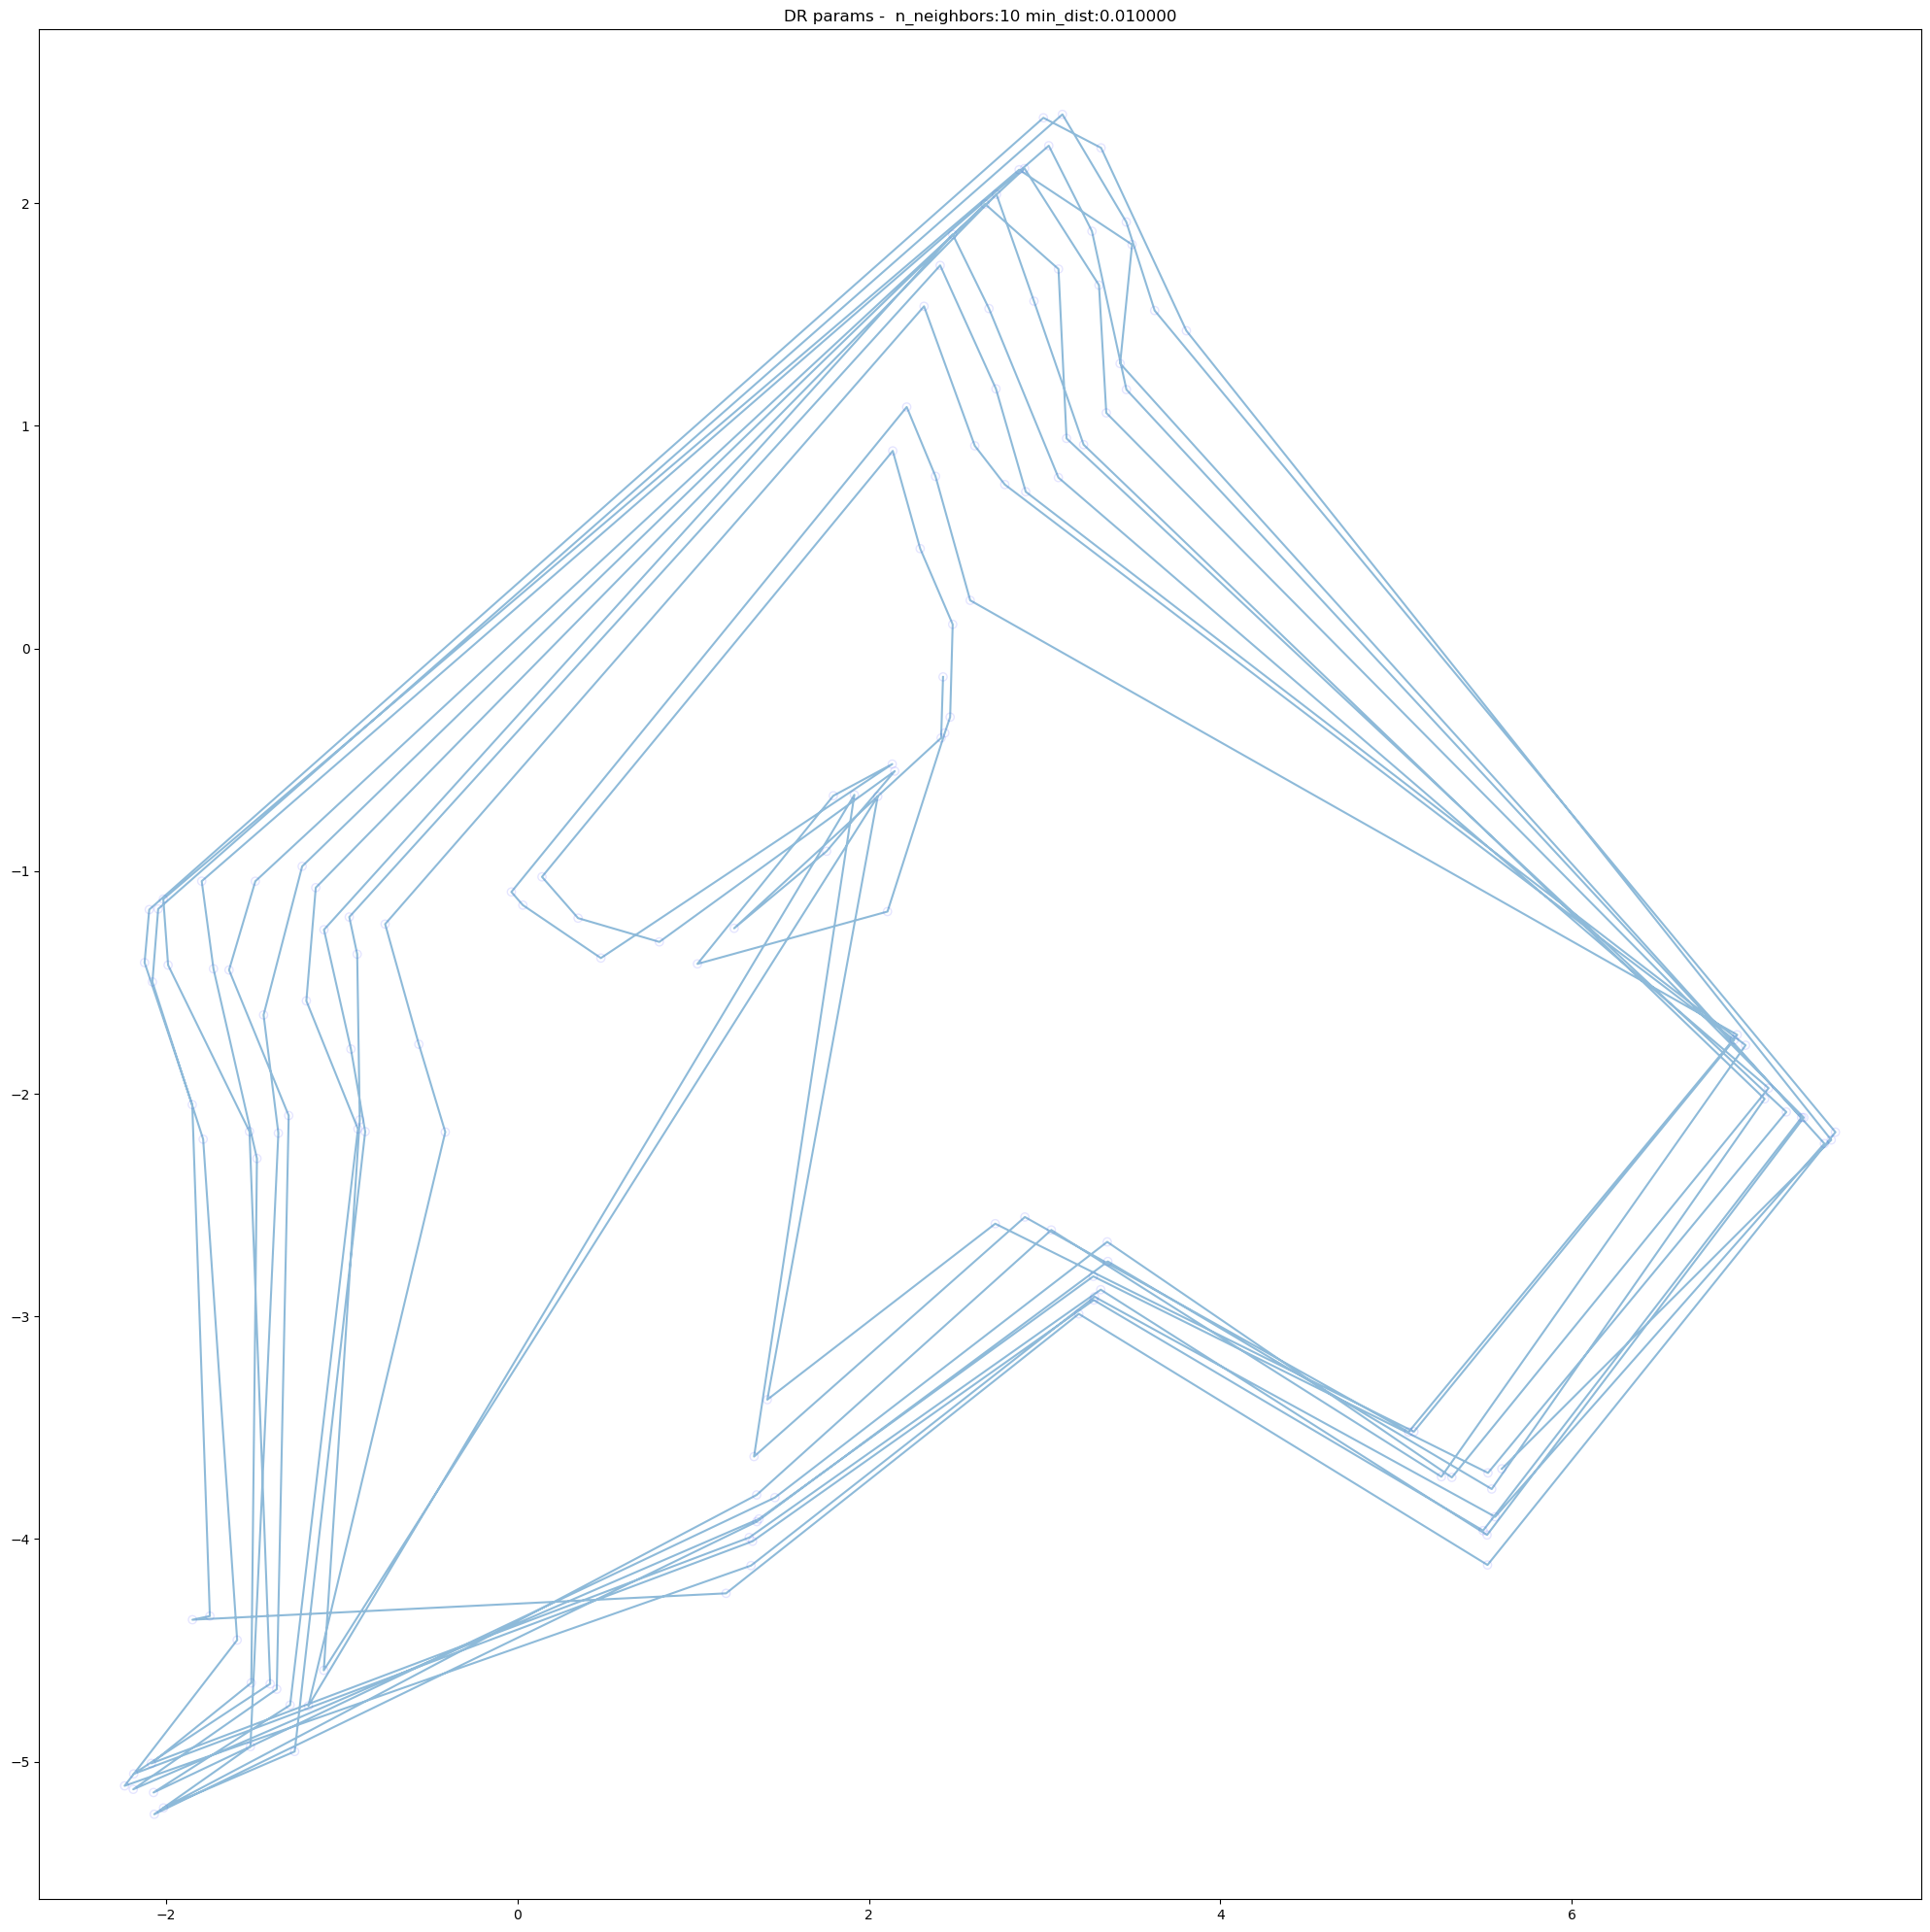

In [24]:
prjs_plt = plot_projections(prjs, umap_params)

[ 5  6 -1  0  2  4  3  1]


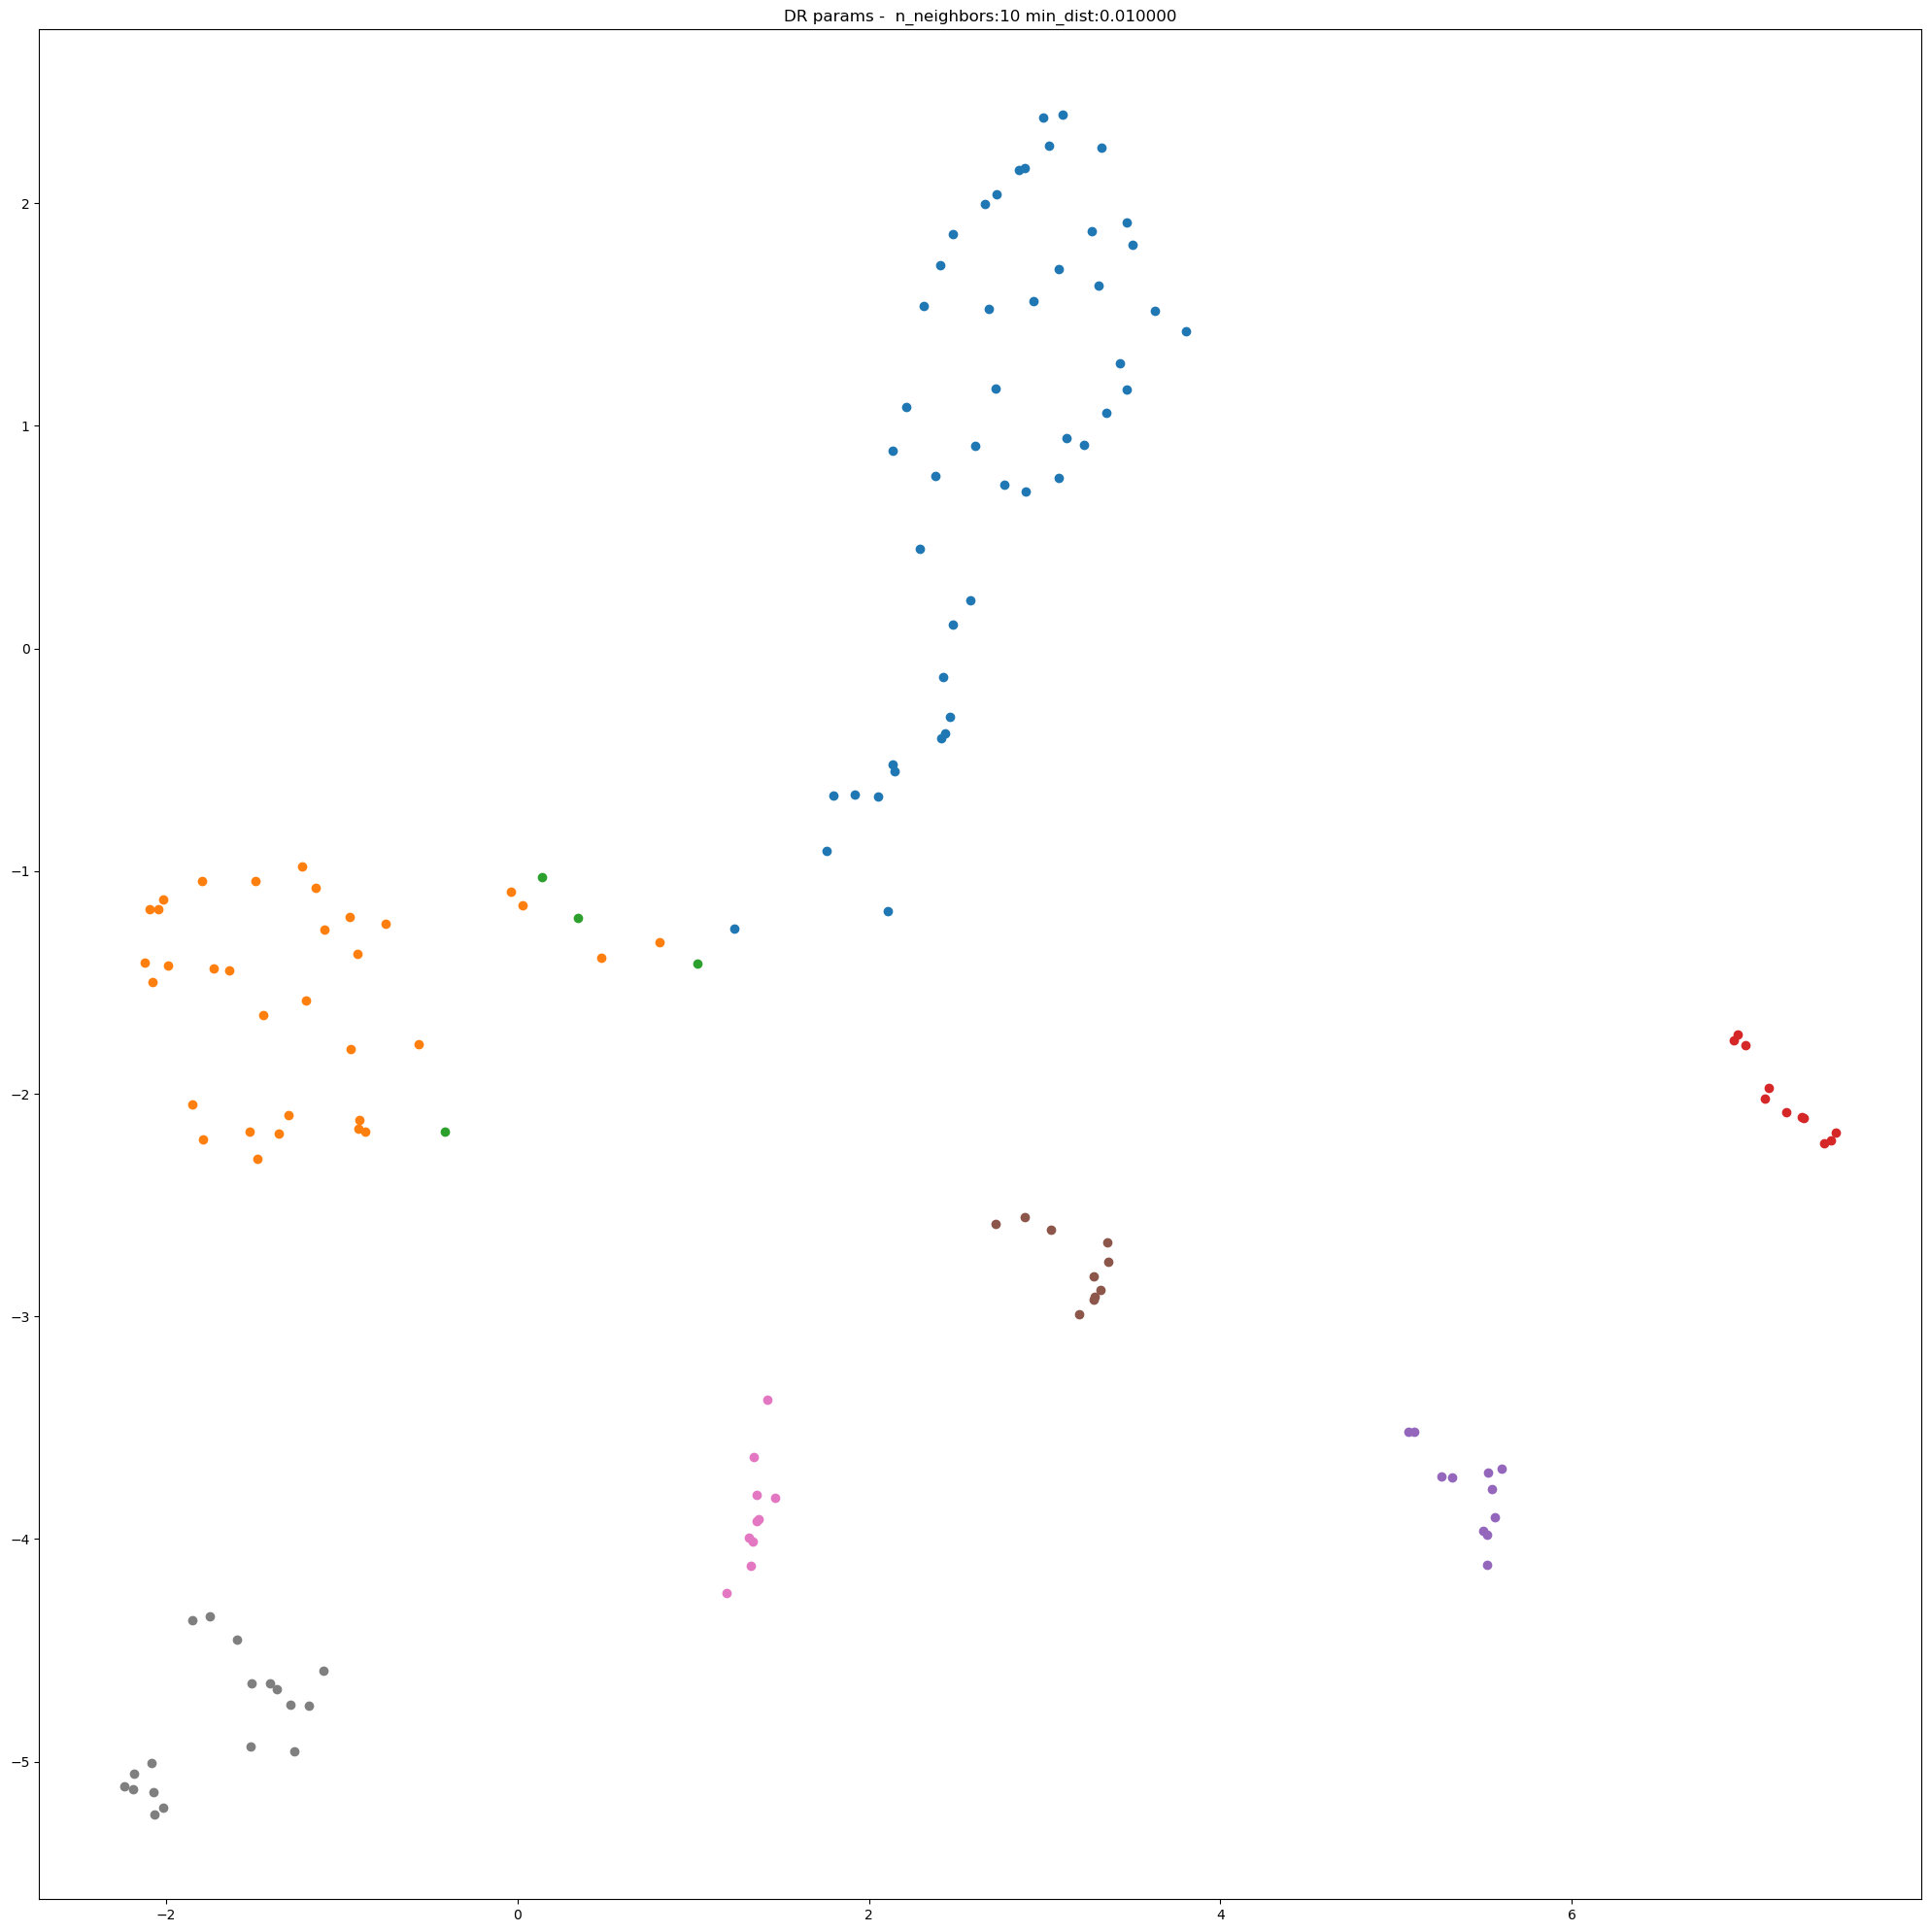

In [25]:
prjs_plt = plot_projections_clusters(prjs, clusters_labels, umap_params)

# Intentemos lo mismo con Toy!

In [26]:
timer.start()
pipeline_toy = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-small",
    device_map="cuda",  # use "cpu" for CPU inference and "mps" for Apple Silicon
    torch_dtype=torch.bfloat16,
)
timer.end()

1726668175.3281705

### Load dataset

In [27]:
#| export
verbose                       = 1  
show_plots                    = False
reset_kernel                  = False
pre_configured_case           = True 
case_id                       = 7 
frequency_factor              = 1
frequency_factor_change_alias = True 
cuda_device                   = 0

In [28]:
#| export
import pandas as pd
import numpy as np
from fastcore.all import *
import wandb
from dvats.load import TSArtifact, infer_or_inject_freq
import pickle
import matplotlib
import matplotlib.pyplot as plt
from tsai.data.external import convert_tsf_to_dataframe
from tsai.utils import stack_pad

In [29]:
base_path = Path.home()

In [30]:
import dvats.config as cfg_

In [31]:
#| export
config = cfg_.get_artifact_config_sd2a(verbose = 0)
if pre_configured_case: 
    print(f"Pre configured case id: {case_id}")
    cfg_.force_artifact_config_sd2a(
        config = config, 
        id = case_id, 
        verbose = verbose, 
        both = verbose > 0, 
        frequency_factor = frequency_factor, 
        frequency_factor_change_alias = frequency_factor_change_alias
    )
cfg_.show_attrdict(config)

Pre configured case id: 7
Selecting  stumpy_toy_0
start_date: None
date_format: %Y-%m-%d %H:%M:%S
csv_config: {'header': None} -> {}
data_cols: [0] -> []
normalize_training: False
freq: 1s
missing_values_technique: None
wandb_artifacts_path: ./data/wandb_artifacts
missing_values_constant: None
artifact_name: PulsusParadoxus-SP02 -> toy
test_split: None
range_training: None
time_col: None
range_testing: None
data_fpath: ~/data/PulsusParadoxusSP02_30_10000.csv -> ~/data/toy.csv
use_wandb: True
date_offset: None
joining_train_test: False
resampling_freq: None
artifact_name: toy
csv_config: {}
data_cols: []
data_fpath: ~/data/toy.csv
date_format: %Y-%m-%d %H:%M:%S
date_offset: None
freq: 1s
joining_train_test: False
missing_values_technique: None
missing_values_constant: None
normalize_training: False
range_training: None
range_testing: None
resampling_freq: None
start_date: None
test_split: None
time_col: None
use_wandb: True
wandb_artifacts_path: ./data/wandb_artifacts


In [32]:
#| export
ext = str(config.data_fpath).split('.')[-1]

if ext == 'pickle':
    df = pd.read_pickle(config.data_fpath)
    
elif ext in ['csv','txt']:
    df = pd.read_csv(config.data_fpath, **config.csv_config)
    
elif ext == 'tsf':
    data, _, _, _, _ = convert_tsf_to_dataframe(os.path.expanduser(config.data_fpath))
    config.update({'start_date': data.start_timestamp[0]}, allow_val_change=True)
    date_format = config.date_format
    df = pd.DataFrame(stack_pad(data.series_value).T)
    
else:
    raise Exception('The data file path has an unsupported extension')

In [33]:
#| export
if config.time_col is not None:
    if verbose > 0: print("time_col: "+str(config.time_col))
    
    if isinstance(config.time_col, int): 
        if verbose > 0: print("Op 1: time_col int")
        datetime = df.iloc[:, config.time_col]
    
    elif isinstance(config.time_col, list): 
        if verbose > 0: print("Op 2: time_col list")
        datetime = df.iloc[:, config.time_col].apply(lambda x: x.astype(str).str.cat(sep='-'), axis=1)
    
    index = pd.DatetimeIndex(datetime)
    
    if config.date_offset:
        index += config.date_offset
    
    df = df.set_index(index, drop=False)   
    
    #Delete Timestamp col
    col_name = df.columns[config.time_col]
    
    if verbose > 0: print("... drop Timestamp col " + str(col_name))
    
    df = df.drop(col_name, axis=1)
    
if verbose > 0: display(df.head())

,T3,T2,T1
0,0.741822,0.637180,0.565117
1,0.739731,0.629415,0.493513
2,0.718757,0.539220,0.469350
3,0.730169,0.577670,0.444100
4,0.752406,0.570180,0.373008


In [34]:
#| export
df = infer_or_inject_freq(
    df, 
    injected_freq=config.freq, 
    start_date=config.start_date, 
    format=config.date_format
)
if verbose > 0: print(df.index.freq)

<Second>


In [35]:
#| export
# Subset of variables
if config.data_cols:
    if verbose > 0: print("data_cols: ", config.data_cols)
    df = df.iloc[:, config.data_cols]

if verbose > 0: print(f'Num. variables: {len(df.columns)}')

Num. variables: 3


In [57]:
df.head()

,T3,T2,T1
1970-01-01 00:00:00,0.741822,0.637180,0.565117
1970-01-01 00:00:01,0.739731,0.629415,0.493513
1970-01-01 00:00:02,0.718757,0.539220,0.469350
1970-01-01 00:00:03,0.730169,0.577670,0.444100
1970-01-01 00:00:04,0.752406,0.570180,0.373008


In [36]:
# Replace the default missing values by np.NaN
if config.missing_values_constant:
    df.replace(config.missing_values_constant, np.nan, inplace=True)

In [37]:
#| export
rg = config.range_training

if isinstance(rg, list):
    rg_training = rg
    
elif isinstance(rg, dict):
    rg_training = pd.date_range(rg['start'], rg['end'], freq=rg['freq'])
    
elif config.test_split:
    rg_training = df.index[:math.ceil(len(df) * (1-config.test_split))]

else:
    rg_training = None
    
df_training = df[df.index.isin(rg_training)] if rg_training is not None else df

In [38]:
#| export
# Testing data
rg = config.range_testing

if rg or config.test_split:
    
    if isinstance(rg, list):
        rg_testing = rg

    elif isinstance(rg, dict):
        rg_testing = pd.date_range(rg['start'], rg['end'], freq=rg['freq'])

    elif config.test_split:
        rg_testing = df.index[math.ceil(len(df) * (1 - config.test_split)):]

    else:
        rg_testing = None
    
    df_testing = df[df.index.isin(rg_testing)]
    testing_artifact = TSArtifact.from_df(df_testing,
                                          name=config.artifact_name, 
                                          missing_values_technique=config.missing_values_technique,
                                          resampling_freq=config.resampling_freq, 
                                          normalize=False,
                                          path=str(Path.home()/config.wandb_artifacts_path))
    display(testing_artifact.metadata)
    if df_testing.index.duplicated().any():
        print("There exist duplicated value(s) in the index dataframe.")
    else:
        if verbose > 0: print("There is no duplicated value in the index dataframe.")
else:
    if verbose > 0: print("rg "+ str(rg) + " | test_split "+ str(config.test_split))
    testing_artifact = None

rg None | test_split None


In [39]:
df.shape

(550, 3)

In [40]:
timer.start()
forecast_toy = pipeline.predict(
    context=torch.tensor(df["T1"]),
    prediction_length=30,
    num_samples=20,
)
timer.end()
timer.show()

[] Start: 1726668175.7236693 | End: 1726668176.091285 | Duration: 0.3676156997680664 seconds


0.3676156997680664

In [41]:
forecast_index = range(len(df), len(df) + 30)
low, median, high = np.quantile(forecast_toy[0].numpy(), [0.1, 0.5, 0.9], axis=0)

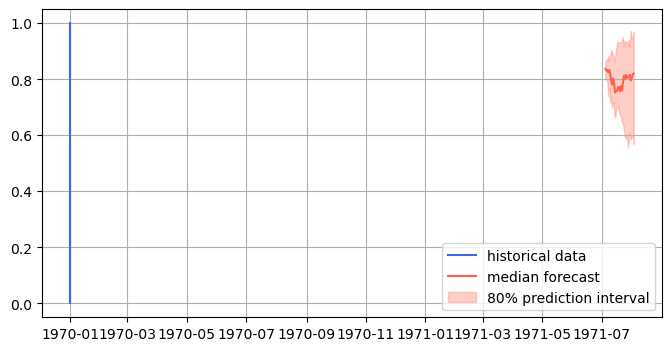

In [42]:
plt.figure(figsize=(8, 4))
plt.plot(df["T1"], color="royalblue", label="historical data")
plt.plot(forecast_index, median, color="tomato", label="median forecast")
plt.fill_between(forecast_index, low, high, color="tomato", alpha=0.3, label="80% prediction interval")
plt.legend()
plt.grid()
plt.show()

In [43]:
context = torch.tensor(df["T1"])
embeddings, tokenizer_state = pipeline.embed(context)

In [44]:
embs = embeddings[0].to(torch.float32).numpy()

In [45]:
prjs = get_UMAP_prjs(embs, cpu=False, **umap_params)

GPU | Used mem: 3
GPU | Used mem: 24
GPU | Memory Usage: [██------------------] 12%
-- cuml.UMAP -- False
GPU | Used mem: 3
GPU | Used mem: 24
GPU | Memory Usage: [██------------------] 12%


In [46]:
clusters = hdbscan.HDBSCAN(**hdbscan_kwargs, **metric_kwargs).fit(prjs)
clusters_labels = clusters.labels_

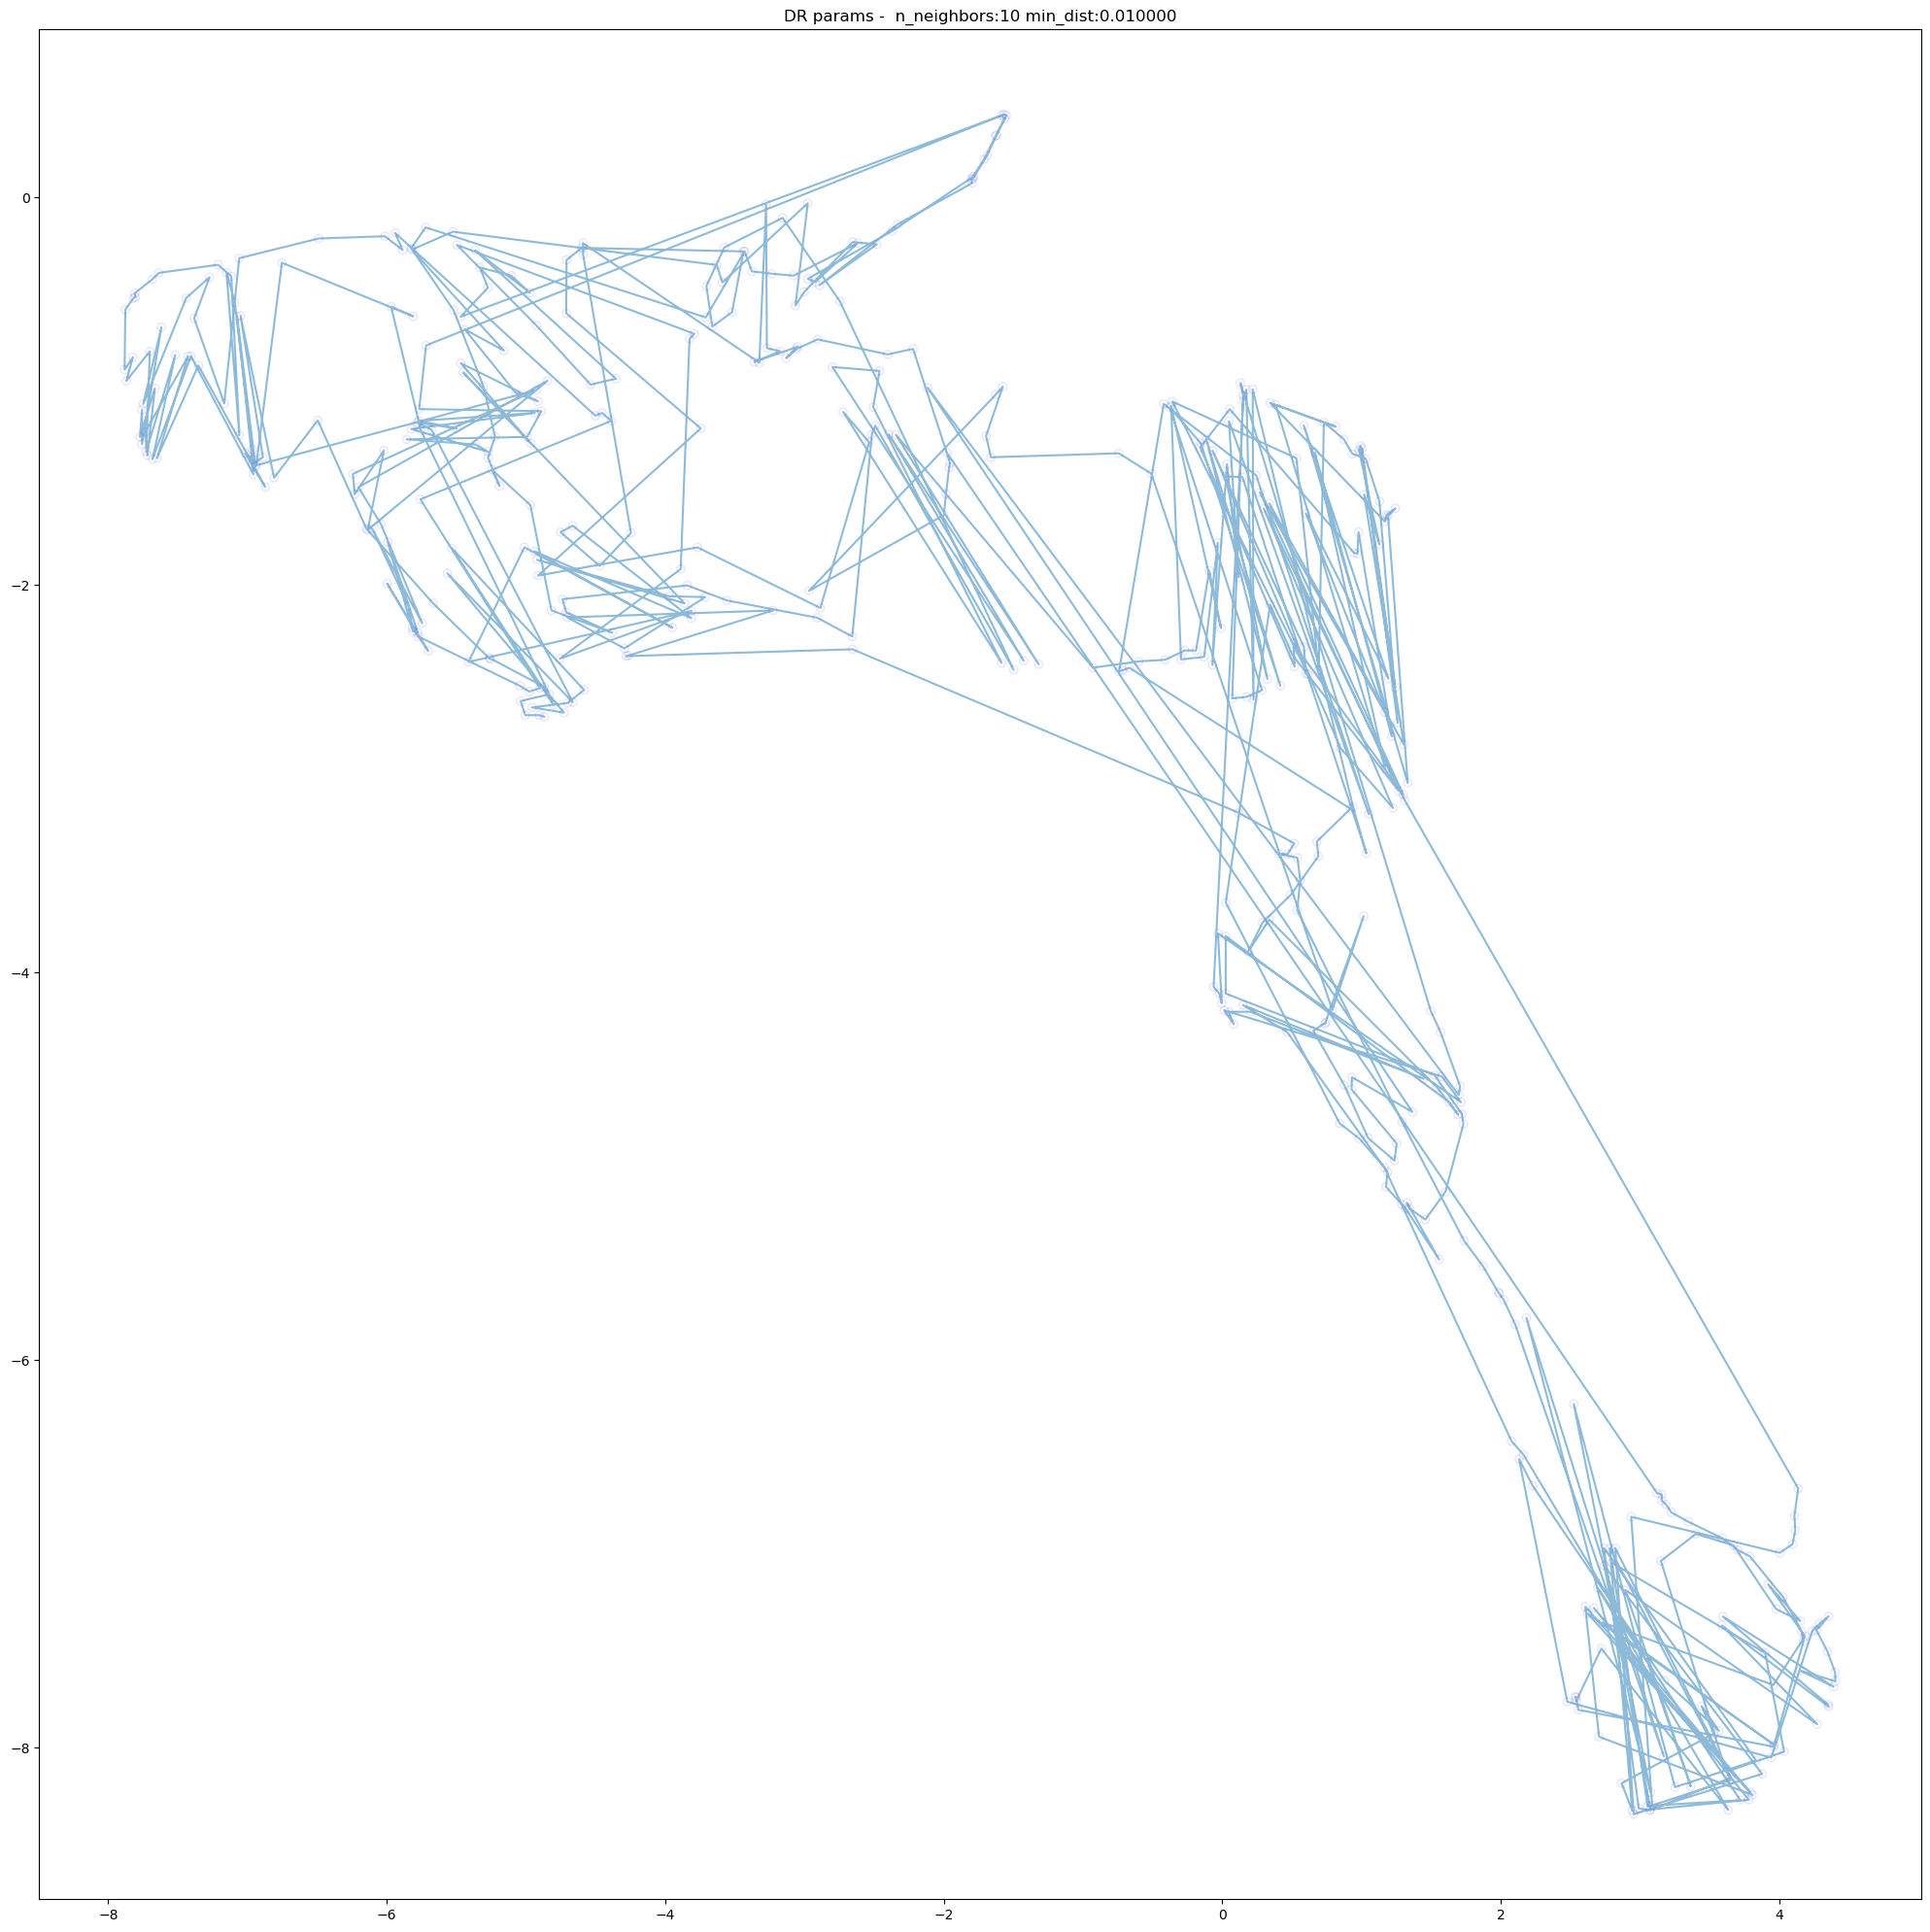

In [47]:
prjs_plt = plot_projections(prjs, umap_params)

[ 7 -1  5  4  2  3  6  1  0]


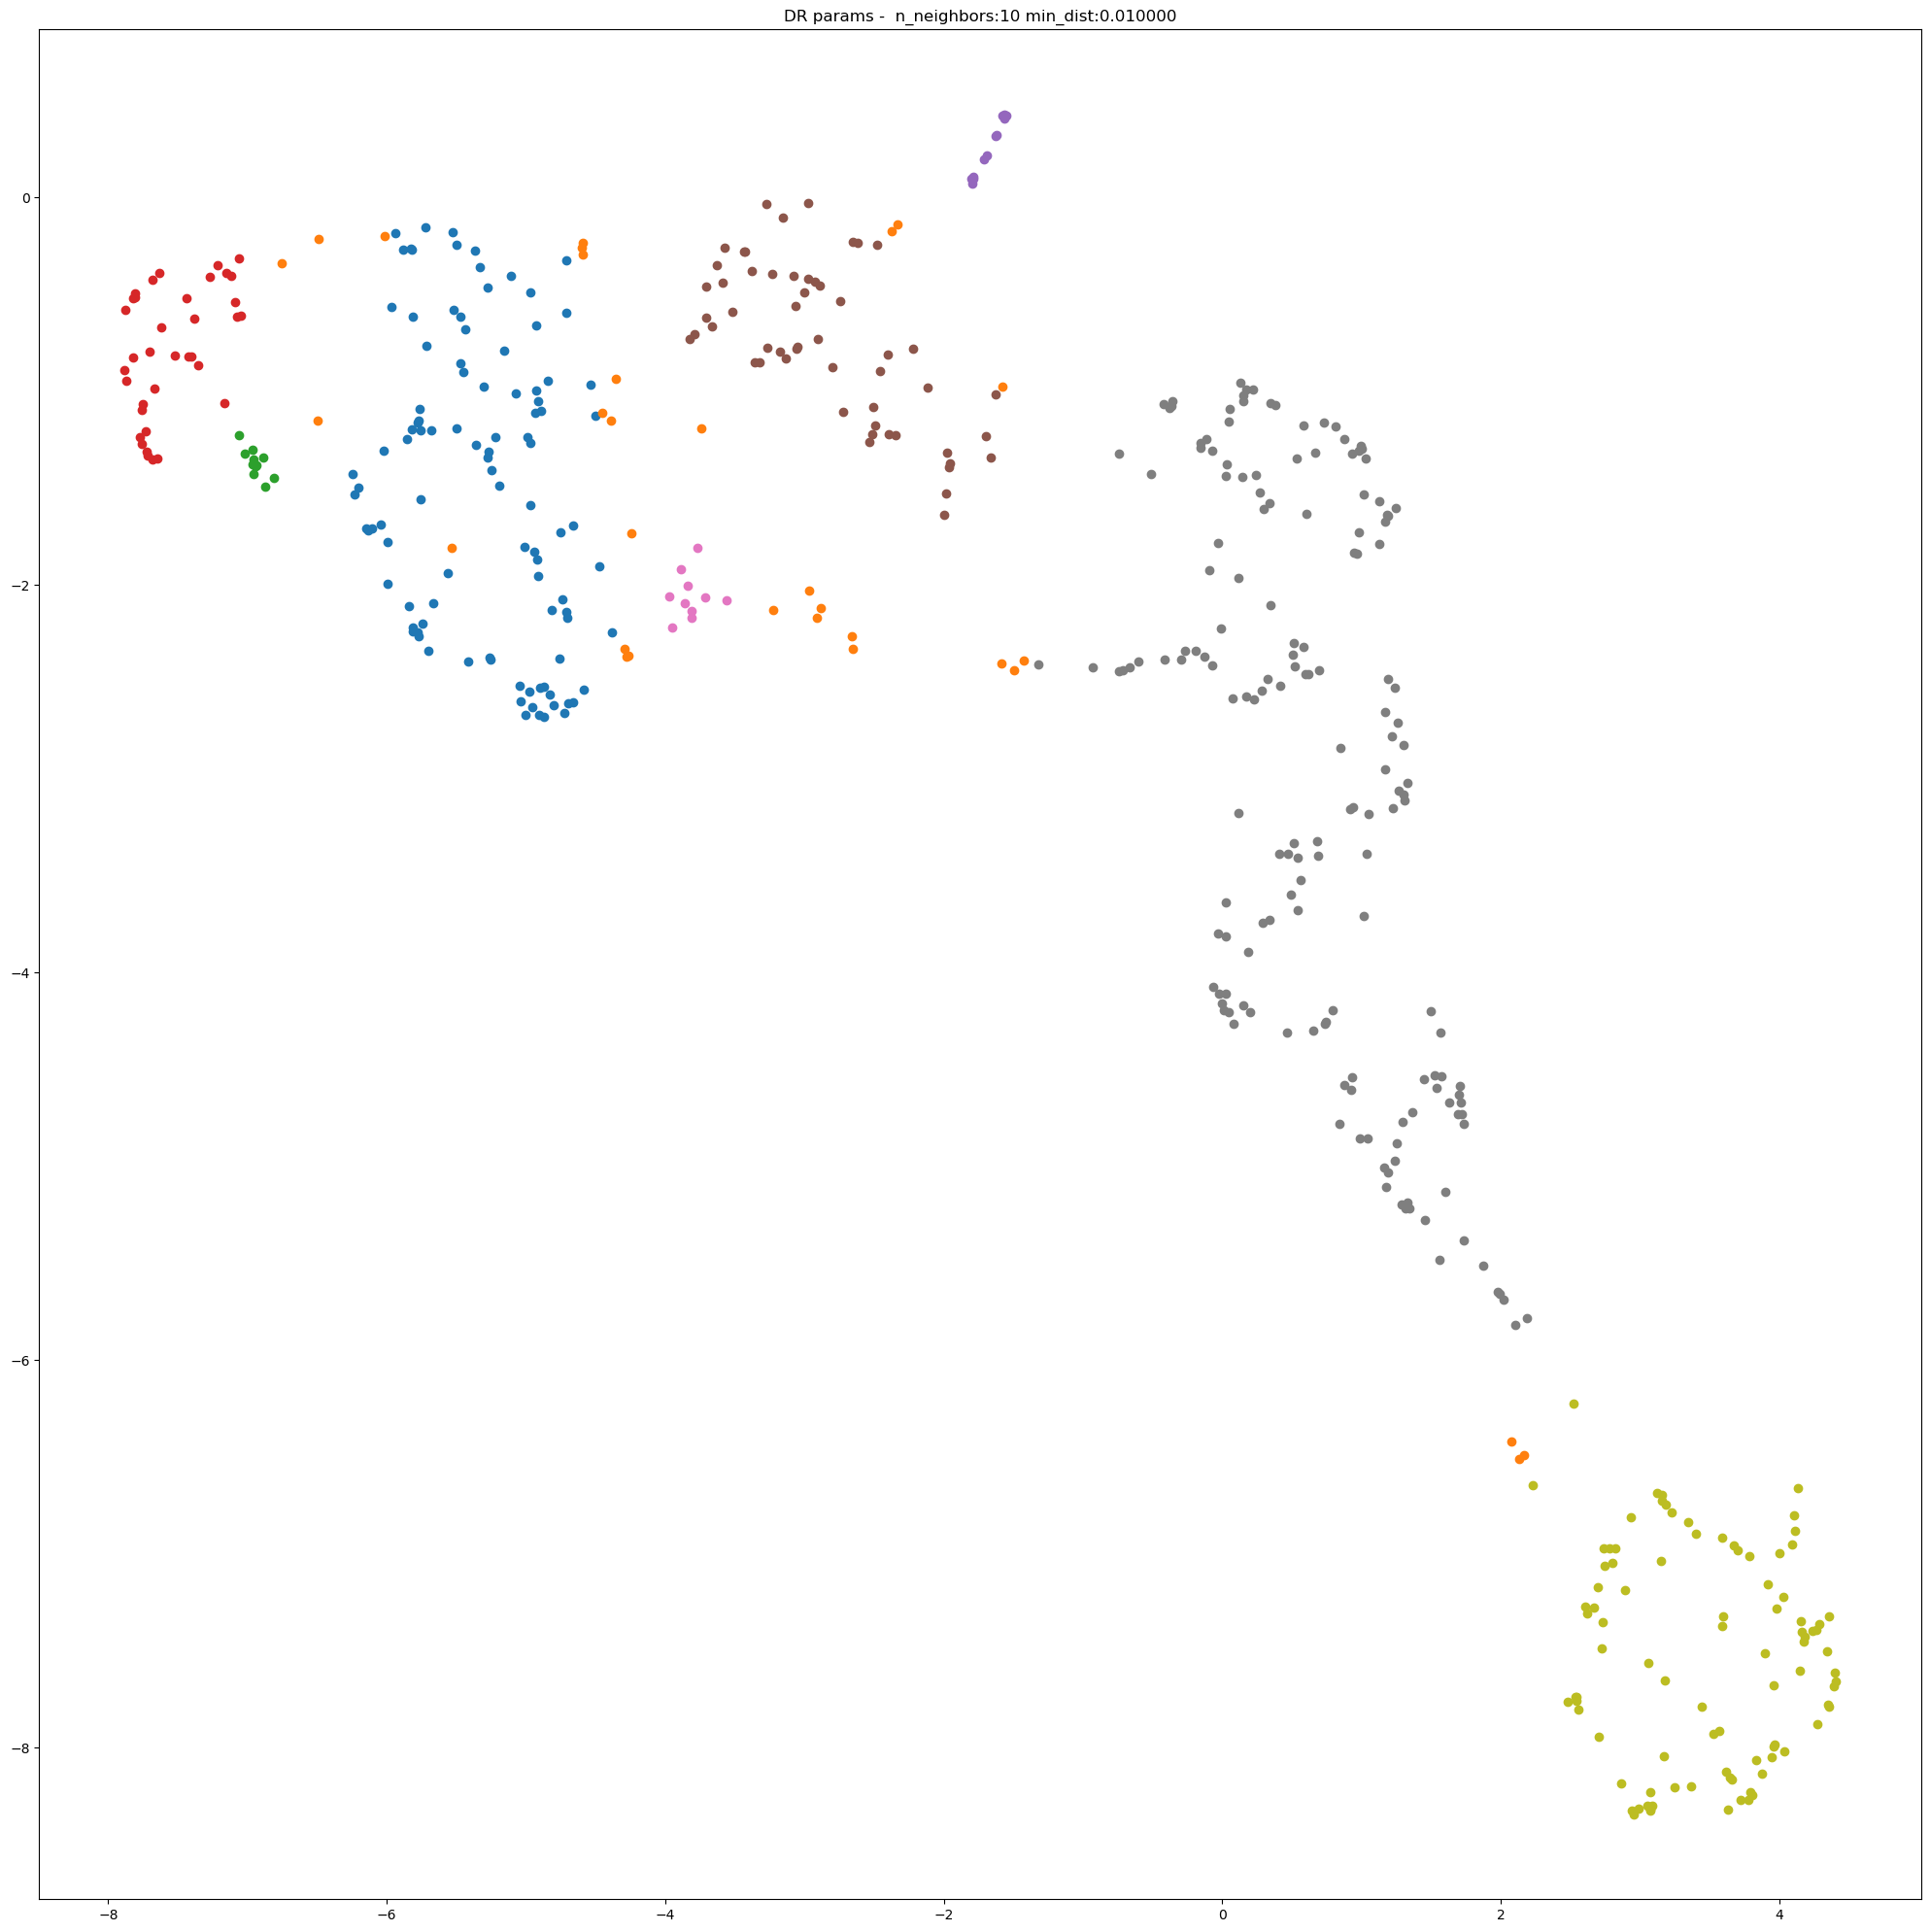

In [48]:
prjs_plt = plot_projections_clusters(prjs, clusters_labels, umap_params)

In [49]:
timer.start()
forecast_toy = pipeline.predict(
    context=torch.tensor(df.values),
    prediction_length=30,
    num_samples=20,
)
timer.end()
timer.show()

[] Start: 1726668178.816599 | End: 1726668180.4645886 | Duration: 1.6479897499084473 seconds


1.6479897499084473

In [50]:
forecast_toy.shape

torch.Size([550, 20, 30])

In [51]:
forecast_index = range(len(df), len(df) + 30)
low, median, high = np.quantile(forecast_toy[0].numpy(), [0.1, 0.5, 0.9], axis=0)

In [52]:
context = torch.tensor(df.values)
embeddings, tokenizer_state = pipeline.embed(context)

In [53]:
prjs = get_UMAP_prjs(embs, cpu=False, **umap_params)

GPU | Used mem: 23
GPU | Used mem: 24
GPU | Memory Usage: [███████████████████-] 96%
-- cuml.UMAP -- False
GPU | Used mem: 23
GPU | Used mem: 24
GPU | Memory Usage: [███████████████████-] 96%


In [54]:
clusters = hdbscan.HDBSCAN(**hdbscan_kwargs, **metric_kwargs).fit(prjs)
clusters_labels = clusters.labels_

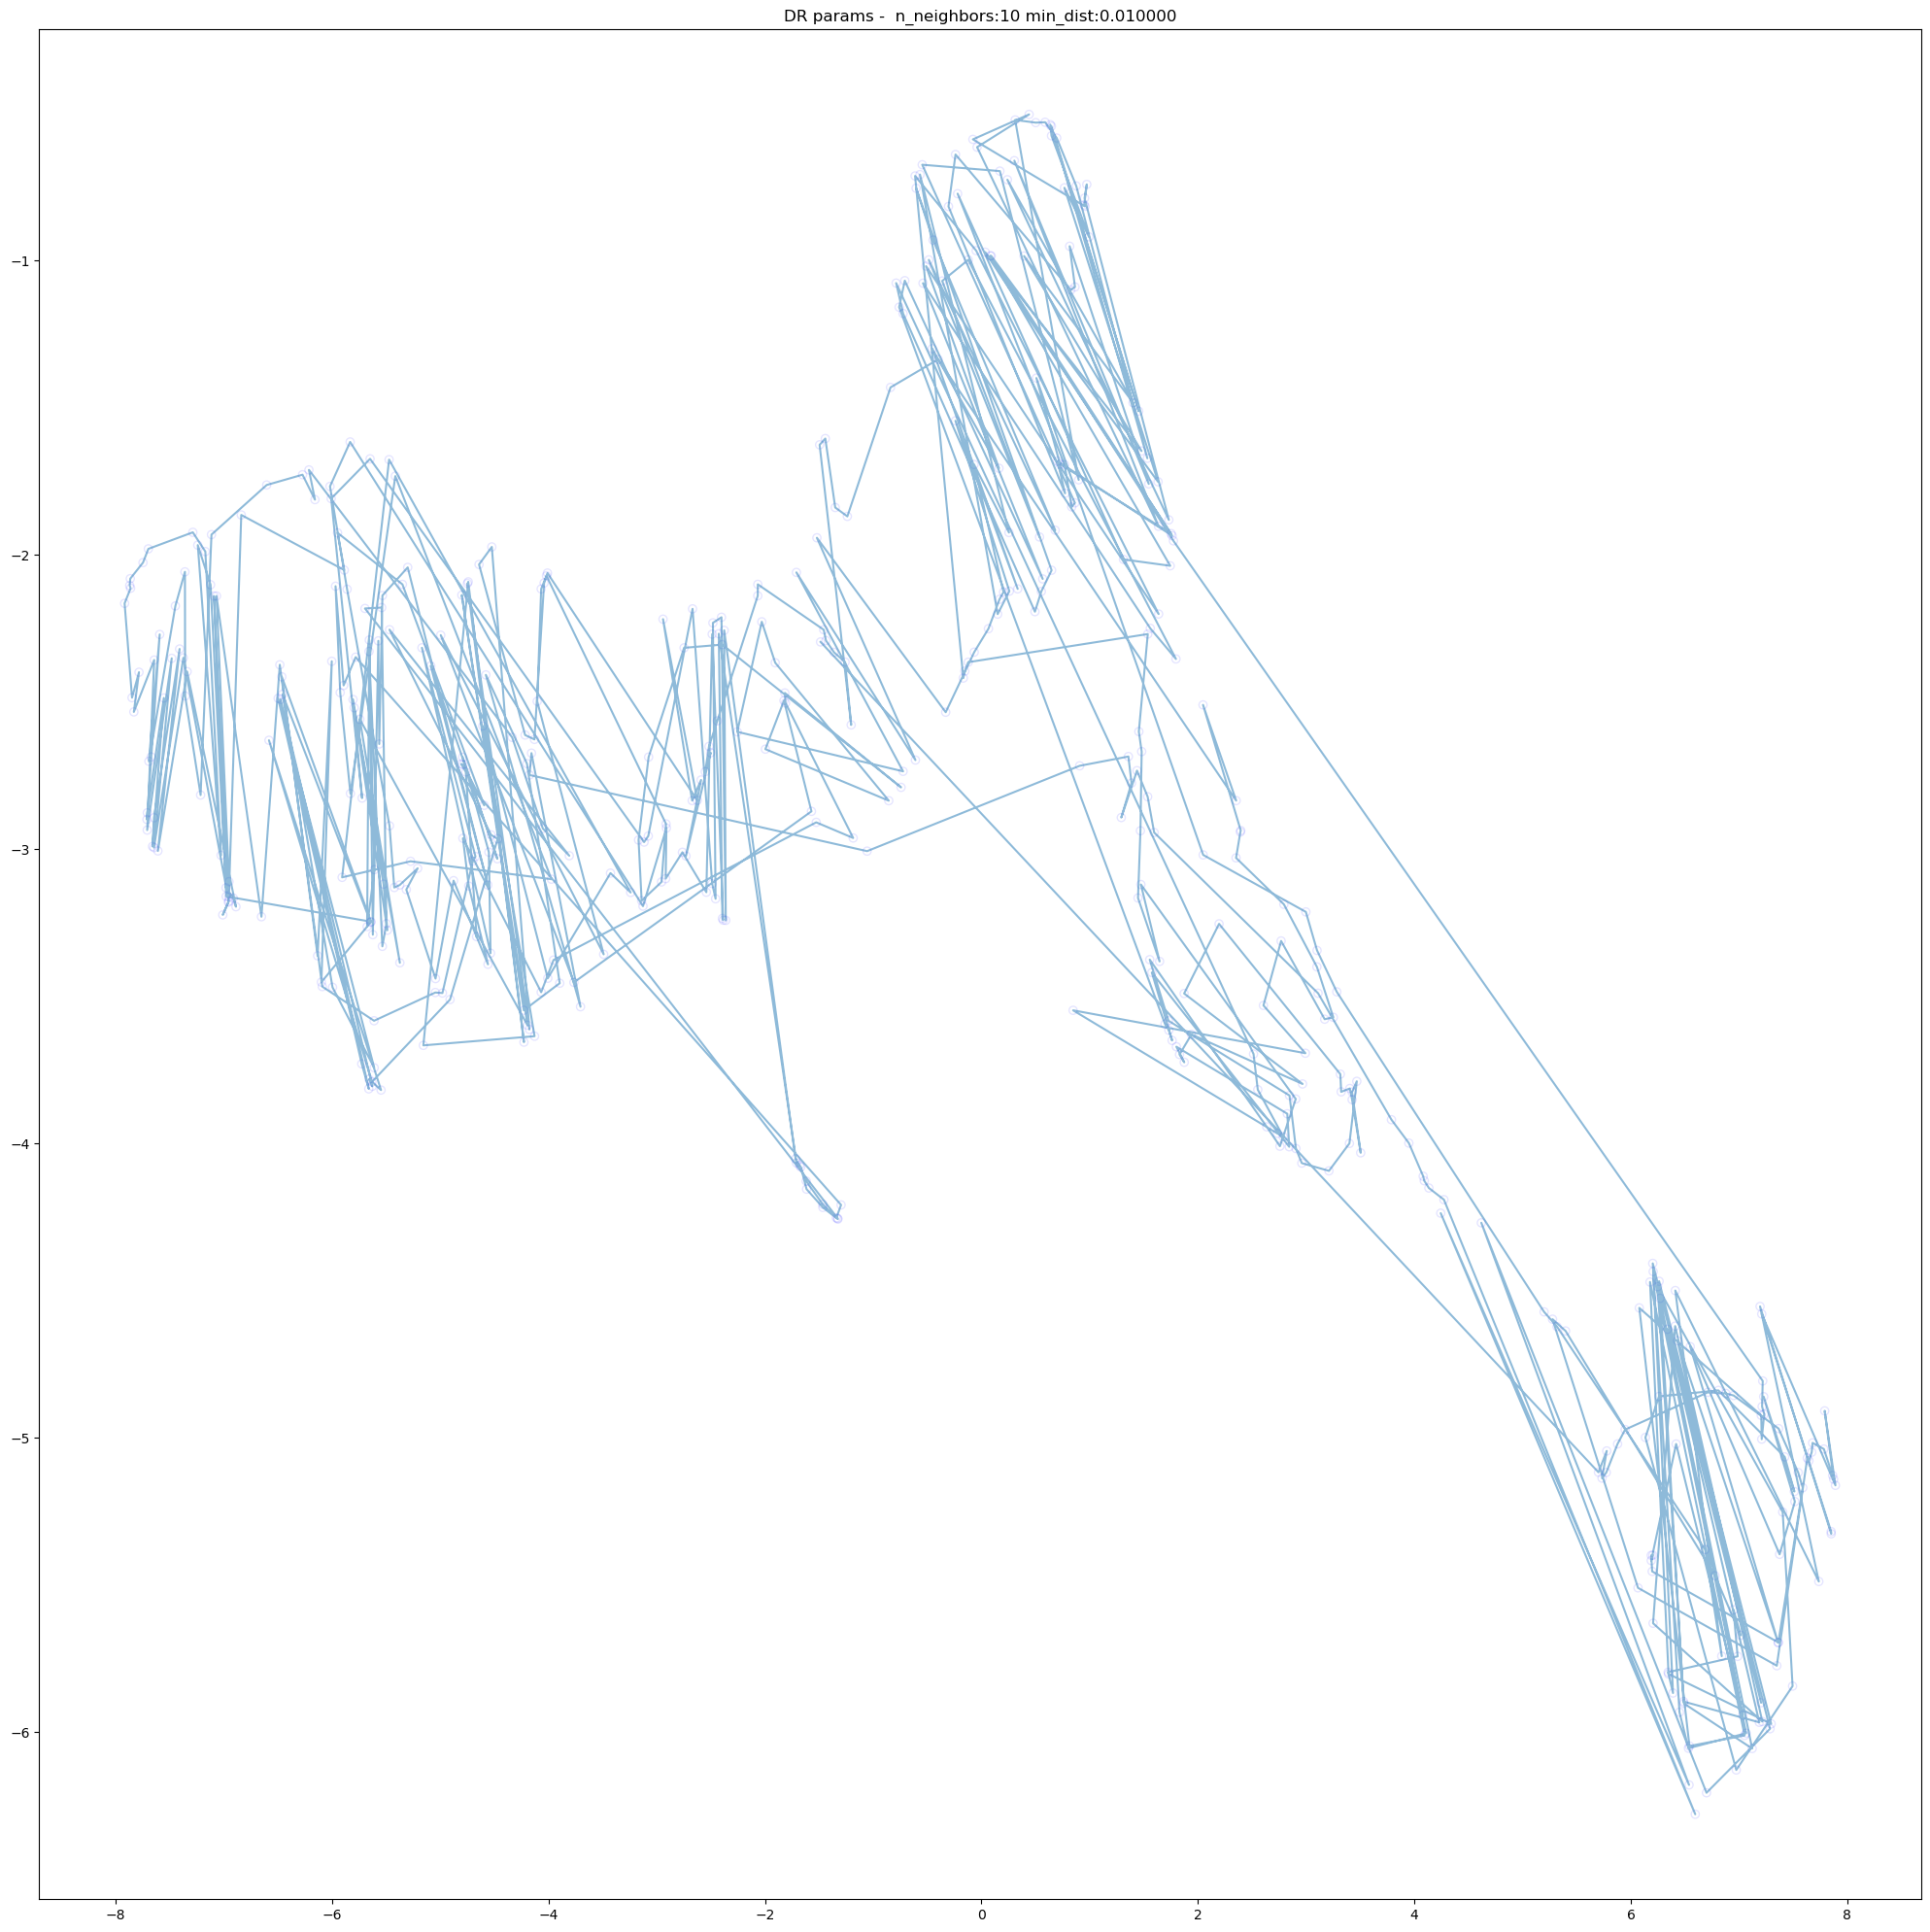

In [55]:
prjs_plt = plot_projections(prjs, umap_params)

[12 -1 13  2  3 15 14  0 10 11  5  6  7  9  8  4  1]


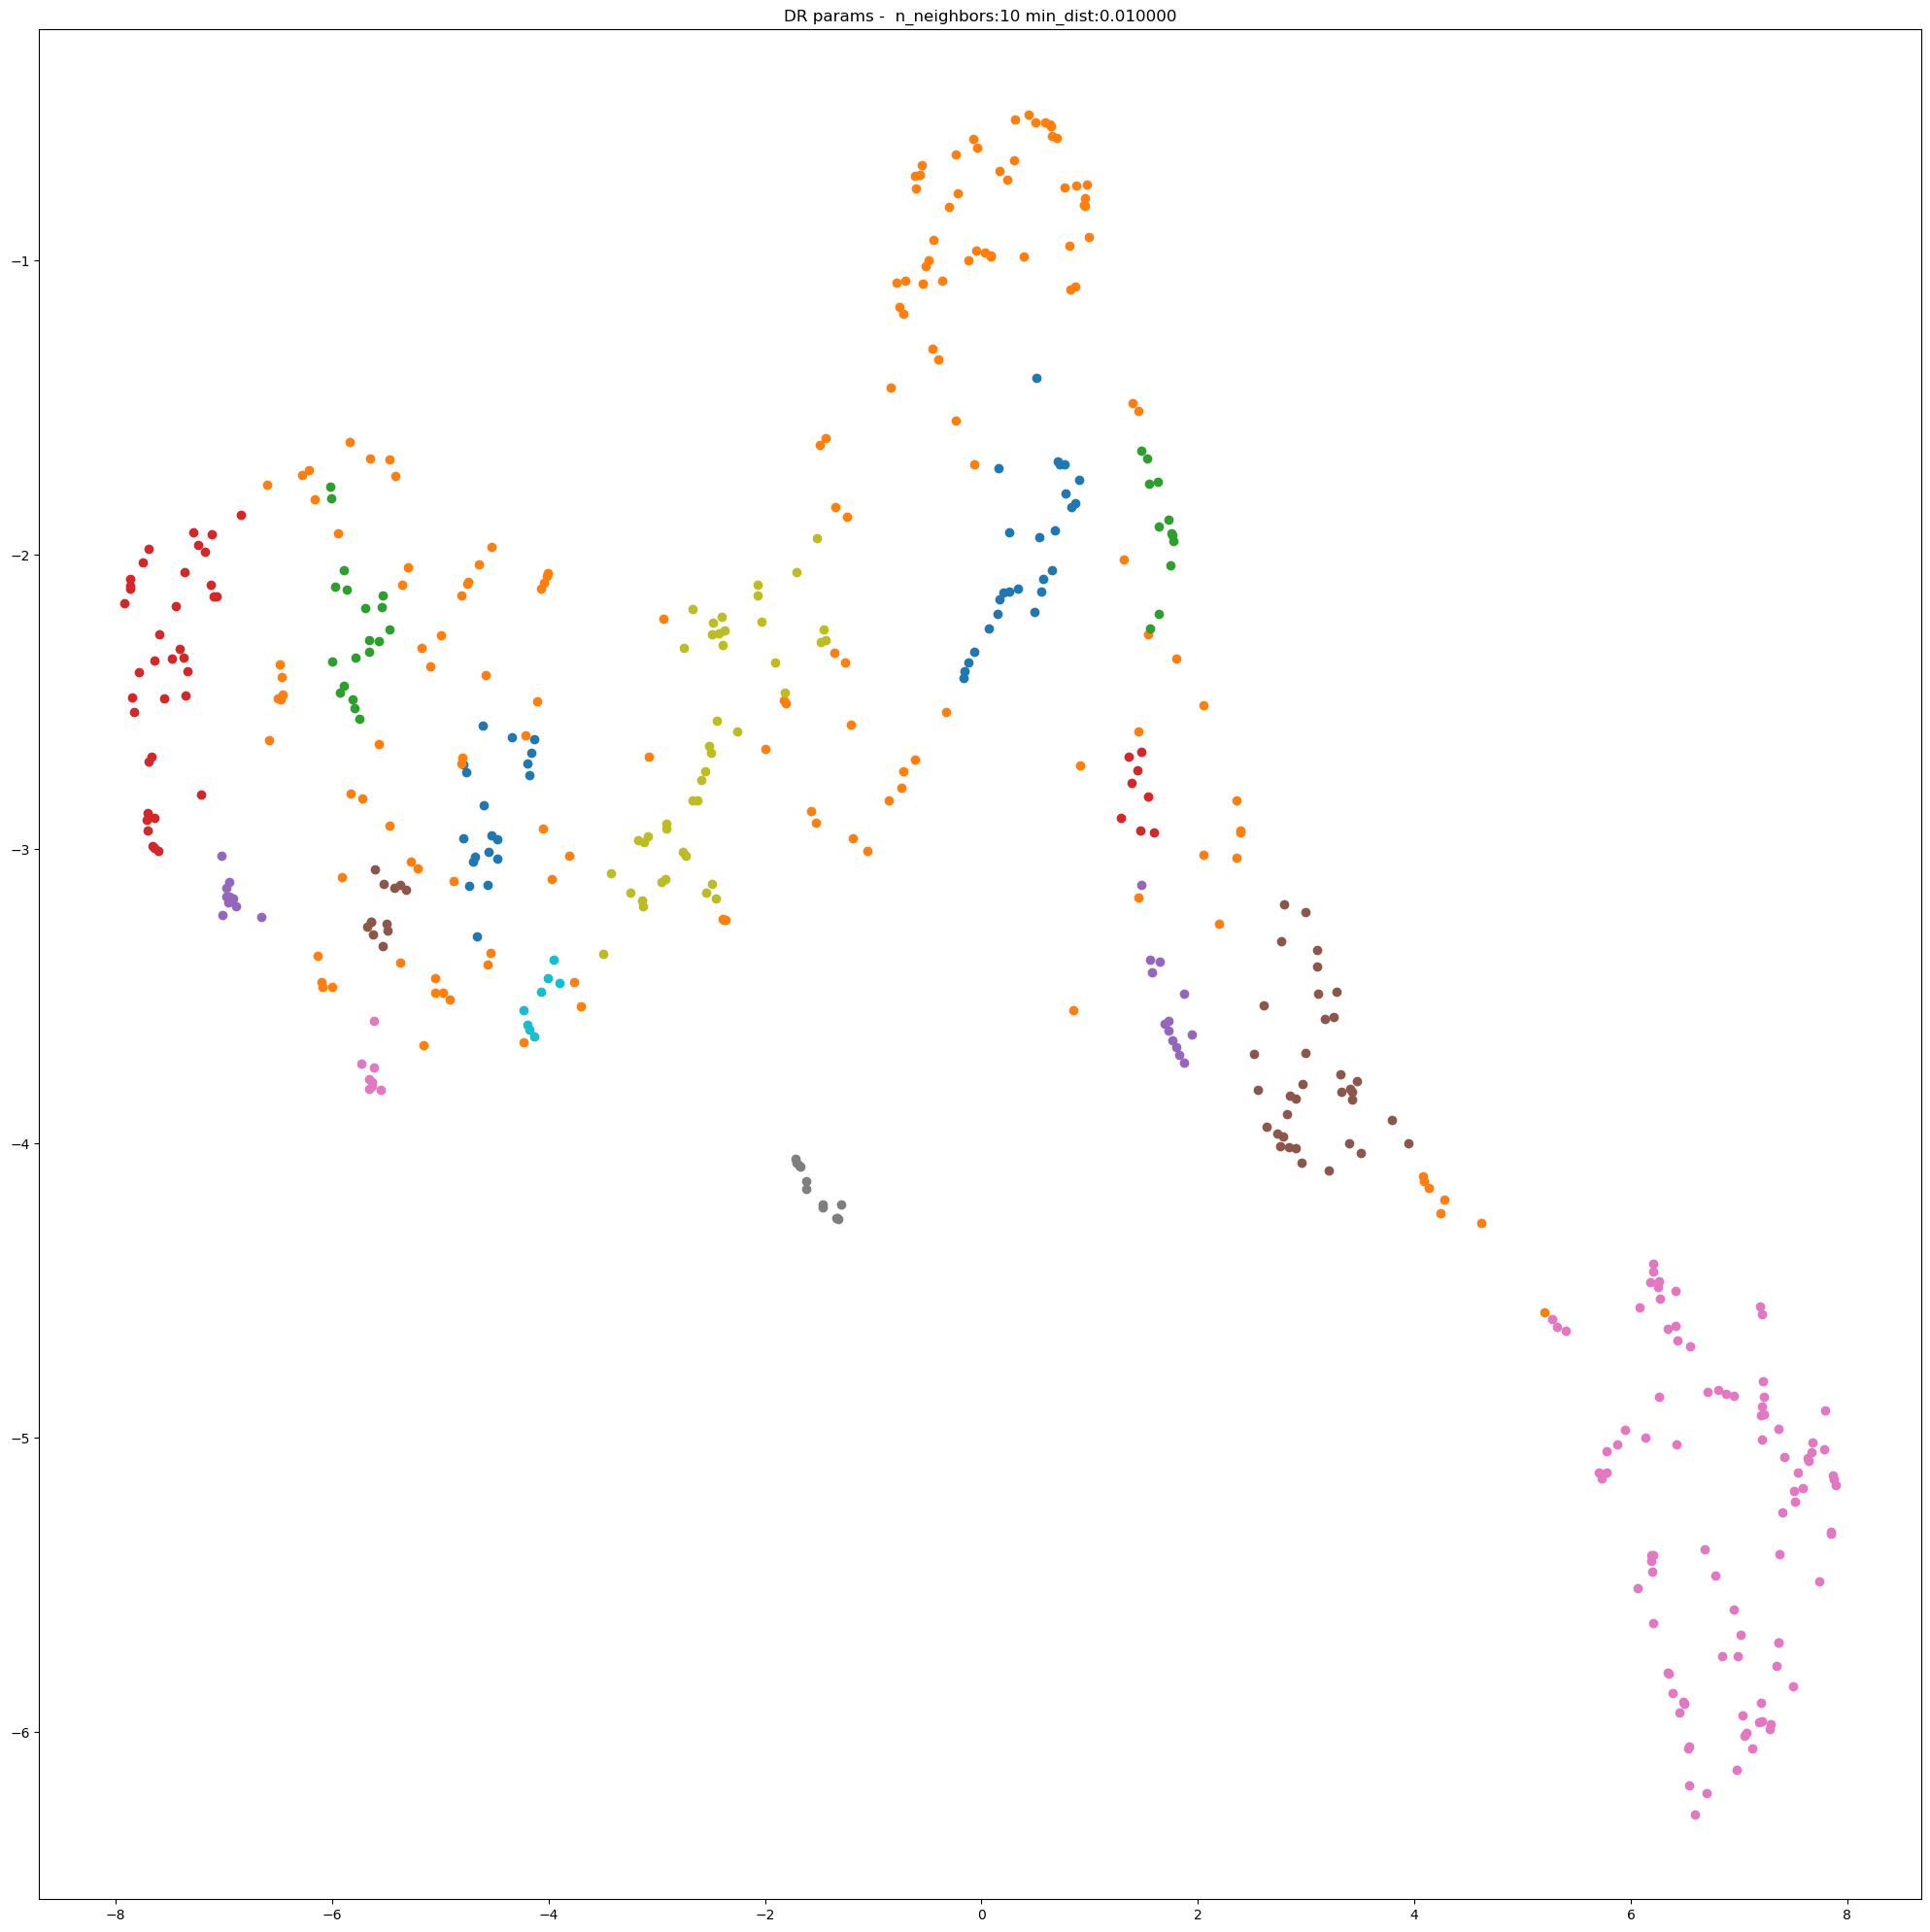

In [56]:
prjs_plt = plot_projections_clusters(prjs, clusters_labels, umap_params)